In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import gc

# BOKEH
import matplotlib.pyplot as plt

# Local imports
#------------------------------------------------
import WireDAQ.PandasPlus           # Make sure this import is after pandas
import WireDAQ.Constants as cst
import WireDAQ.NXCALS as nx
import WireDAQ.Parser as parser
import WireDAQ.Efficiency as eff


# Creating NXCALS variable containers
#------------------------------------------------
wires     = {'B1': [nx.NXCALSWire(loc = loc) for loc in ['L1B1','L5B1']],
             'B2': [nx.NXCALSWire(loc = loc) for loc in ['R1B2','R5B2']]}
beams     = [nx.NXCALSBeam(name) for name in ['B1','B2']]
LHC       = nx.NXCALSLHC()
b_slots   = np.arange(3564)
#------------------------------------------------


# Setting default values
#------------------------------------------------
_default_fig_width  = 2000
_default_fig_height = 400
_default_fig_pad    = 100

_default_device = 'DBLM'

_default_path     = '/eos/project/l/lhc-lumimod/LuminosityFollowUp/2023/'
_default_out      = '/eos/user/p/phbelang/www/Monitoring_BBCW/DBLM'



>>> Loading nx2pd.py version of 24.10.2022 @ 03:17PM



In [3]:
FILL = 8685
data_path = _default_path
# Fixing data path
raw_data    = data_path + '/rawdata/'


# Finding filling pattern
#-------------------------------------------------
bb_df_b1,bb_df_b2 = parser.fill_filling_pattern(fill=FILL,data_path= raw_data,n_LR = 21)
#-------------------------------------------------

# Declaring master bin times
#-------------------------------------------------
dt = 20
unix_s,unix_e = parser.fill_unix_times(FILL,data_path=raw_data )
unix_bins     = np.arange(unix_s,unix_e,dt/1e-9)
#-------------------------------------------------

# Import BCTF and calibrate
#-------------------------------------------------
variables = []
for beam in beams:
    variables += beam._getVarList(subset=['bb_Intensity','bb_Intensity_B'])

bctf = parser.from_parquet2bin(fill=FILL,variables = variables,bins=unix_bins,beamMode = None,data_path= raw_data )
bct  = parser.from_parquet2bin(fill=FILL,variables = [beam.Intensity for beam in beams],bins=unix_bins,keeptype=False,data_path= raw_data )

_tmp    = pd.concat([bct,bctf],axis=1).sort_index()
bct_avg = compute_BCT_avg(_tmp)
#-------------------------------------------------

# Import lumi and compute total lumi
#-------------------------------------------------
variables  = [LHC.bb_Luminosity['ATLAS'],LHC.bb_Luminosity['CMS']]
df_lumi     = parser.from_parquet(fill=FILL,variables = variables,beamMode = None,data_path= raw_data )
df_lumi_tot = eff.compute_lumi_tot(df_lumi,experiments = ['ATLAS','CMS'])
#-------------------------------------------------


_tmp   = pd.concat([bct_avg,df_lumi_tot],axis=1).sort_index()
df_eff = compute_BCTF_efficiency(_tmp,beams,smooth_window= 9 ,smooth_iter = 1)


/tmp/ipykernel_237988/1869610065.py:184: RuntimeWarning: divide by zero encountered in divide
  eta      = cst.SIG_PP*data_L/(-dNdt)


In [2]:
def first_order_diff(x,dt):
    # Taken from
    # https://github.com/luckystarufo/PyNumDiff/blob/upgrade/pynumdiff/finite_difference/_finite_difference.py

    # Calculate the finite difference
    dxdt_hat = np.diff(x,axis=0) / dt
    
    # Pad the data
    dxdt_hat = np.vstack((dxdt_hat[0,:], dxdt_hat, dxdt_hat[-1,:]))
    
    # Re-finite dxdt_hat using linear interpolation
    dxdt_hat = np.mean((dxdt_hat[0:-1,:], dxdt_hat[1:,:]), axis=0)

    return dxdt_hat

def compute_BCT_avg(df,return_raw=False):

    
    idx_max = df[beams[0].Intensity].argmax()
    s_calib = int(df.index[idx_max] + 2*60*1e9)
    e_calib = int(s_calib + 10*60*1e9)

    new_dict = {}
    for beam in beams:

        observable = beam['Intensity']
        ref   = _tmp[observable].dropna()
        times = ref.index 



        observable = beam['bb_Intensity']
        total_A    = df[observable].dropna()
        calib_A    = np.mean((ref/total_A.apply(lambda line: np.sum(line))).loc[s_calib:e_calib])

        new_dict[f'bb_Intensity_A_{beam.name}'] = total_A*calib_A

        observable = beam['bb_Intensity_B']
        total_B    = df[observable].dropna()
        calib_B    = np.mean((ref/total_B.apply(lambda line: np.sum(line))).loc[s_calib:e_calib])

        # B1 BCTFR-B needs rolling of 1 bucket (let's make it general):
        #-------------------------------------
        
        rolling = b_slots[(total_A.loc[s_calib:].iloc[0]>0.5e10)&(b_slots<3562)][-1]-b_slots[(total_B.loc[s_calib:].iloc[0]>0.5e10)&(b_slots<3562)][-1]
        if rolling != 0 :
            total_B = total_B.apply(lambda line: np.roll(line,rolling))
            print(f'MISALIGNED {beam.name}, ROLLING BY {rolling}')
        
        #-------------------------------------

        new_dict[f'bb_Intensity_B_{beam.name}']   = total_B*calib_B

        new_dict[f'bb_Intensity_avg_{beam.name}'] = (new_dict[f'bb_Intensity_A_{beam.name}'] + new_dict[f'bb_Intensity_B_{beam.name}'])/2

    # Removing raw data
    #-----------------------------
    if not return_raw:
        new_dict.pop('bb_Intensity_A_B1')
        new_dict.pop('bb_Intensity_B_B1')
        new_dict.pop('bb_Intensity_A_B2')
        new_dict.pop('bb_Intensity_B_B2')
    #-----------------------------
        del(total_A)
        del(total_B)
        del(ref)
    gc.collect()
    #-----------------------------

    return pd.DataFrame(new_dict)


import scipy.interpolate as sciInterp
# def compute_BCTF_efficiency(df,beams):



#     # Extracting Lumi
#     #-----------------------------------------
#     observable     = 'bb_LUMI_TOT'
#     times_L,data_L = df[observable].dropna().to_2D()
#     #-----------------------------------------

#     # Fixing time vector
#     #---------------------------------
#     crop_by   = 10
#     _tmp_time = df[f'bb_Intensity_avg_B1'].dropna().index
#     dt        = np.min(np.diff(_tmp_time))
#     times     = np.arange(_tmp_time[0],_tmp_time[-1],dt)[crop_by:-crop_by]
#     #---------------------------------

#     # Aligning lumi with interpolation
#     #---------------------------------
#     data_L  = 1e6*sciInterp.interp1d(times_L,data_L,axis=0,bounds_error=False,fill_value=np.nan)(times)
#     #---------------------------------

#     per_beam_results = {}
#     for beam in beams:

#         observable     = f'bb_Intensity_avg_{beam.name}'
#         times_N,data_N = df[observable].dropna().to_2D()


#         # Aligning times with interpolation
#         #---------------------------------
#         data_N  =     sciInterp.interp1d(times_N,data_N,axis=0)(times)
#         #---------------------------------

#         # Computing efficiency
#         #---------------------------------
#         dNdt     = first_order_diff(data_N,dt/1e9)
#         eta      = cst.SIG_PP*data_L/(-dNdt)
#         sig_eff  = cst.SIG_PP/eta
#         #---------------------------------

#         # Unpacking results
#         per_beam_results[f'{beam.name}:eta']     = list(eta)
#         per_beam_results[f'{beam.name}:sig_eff'] = list(sig_eff)


#     # Removing raw data
#     #-----------------------------
#     del(data_L)
#     del(data_N)
#     del(dNdt)
#     gc.collect()
#     #-----------------------------

#     return pd.DataFrame(per_beam_results,index=times)


import pynumdiff
def compute_BCTF_efficiency(df,beams,smooth_window= None ,smooth_iter = 1):



    # Extracting Lumi
    #-----------------------------------------
    observable     = 'bb_LUMI_TOT'
    times_L,data_L = df[observable].dropna().to_2D()
    #-----------------------------------------

    # Fixing time vector
    #---------------------------------
    crop_by   = 10
    _tmp_time = df[f'bb_Intensity_avg_B1'].dropna().index
    dt        = np.min(np.diff(_tmp_time))
    times     = np.arange(_tmp_time[0],_tmp_time[-1],dt)[crop_by:-crop_by]
    #---------------------------------

    # Aligning lumi with interpolation
    #---------------------------------
    data_L  = 1e6*sciInterp.interp1d(times_L,data_L,axis=0,bounds_error=False,fill_value=np.nan)(times)
    #---------------------------------

    per_beam_results = {}
    for beam in beams:

        observable     = f'bb_Intensity_avg_{beam.name}'
        times_N,data_N = df[observable].dropna().to_2D()

        # Computing dNdt
        #---------------------------------
        if smooth_window is not None:
            # Computing dNdt
            dNdt   = np.nan*data_N.copy()
            for bucket in b_slots:
                N_hat,dNdt_hat  = pynumdiff.smooth_finite_difference.meandiff(data_N[:,bucket], dt/1e9, [smooth_window,smooth_iter], options={'iterate': True})
                # N_hat,dNdt_hat  = pynumdiff.smooth_finite_difference.gaussiandiff(data_N[:,bucket], dt/1e9, smooth_params, options={'iterate': True})
                dNdt[:,bucket]   = dNdt_hat
                data_N[:,bucket] = N_hat 
        else:
            data_N = sciInterp.interp1d(times_N,data_N,axis=0)(times)
            dNdt   = first_order_diff(data_N,dt/1e9)
        #---------------------------------

        # Aligning times with interpolation
        #---------------------------------
        dNdt  =     sciInterp.interp1d(times_N,dNdt,axis=0,bounds_error=False,fill_value=np.nan)(times)
        #---------------------------------

        # Computing efficiency
        #---------------------------------
        eta      = cst.SIG_PP*data_L/(-dNdt)
        sig_eff  = cst.SIG_PP/eta
        #---------------------------------

        # Unpacking results
        per_beam_results[f'{beam.name}:eta']     = list(eta)
        per_beam_results[f'{beam.name}:sig_eff'] = list(sig_eff)


    # Removing raw data
    #-----------------------------
    del(data_L)
    del(data_N)
    del(dNdt)
    gc.collect()
    #-----------------------------

    return pd.DataFrame(per_beam_results,index=times)



2023-06-07 10:11:52,278 [INFO] 
Limited Total Variation Regularization Support Detected! 
---> CVXPY is not installed. 
---> Many Total Variation Methods require CVXPY including: 
---> velocity, acceleration, jerk, jerk_sliding, smooth_acceleration
---> Please install CVXPY to use these methods.
---> Recommended to also install MOSEK and obtain a MOSEK license.
You can still use: total_variation_regularization.iterative_velocity

2023-06-07 10:11:52,280 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 

2023-06-07 10:11:52,281 [INFO] 
Limited Linear Model Support Detected! 
---> CVXPY is not installed. 
---> Install CVXPY to use lineardiff derivatives 
You can still use other methods 



# Bunch and beamm

In [7]:
%matplotlib widget
beam = beams[1]
bunches = [bb_df_b1.index[100],bb_df_b1.index[110]]
bunches = [1113,1138]

# Raw data

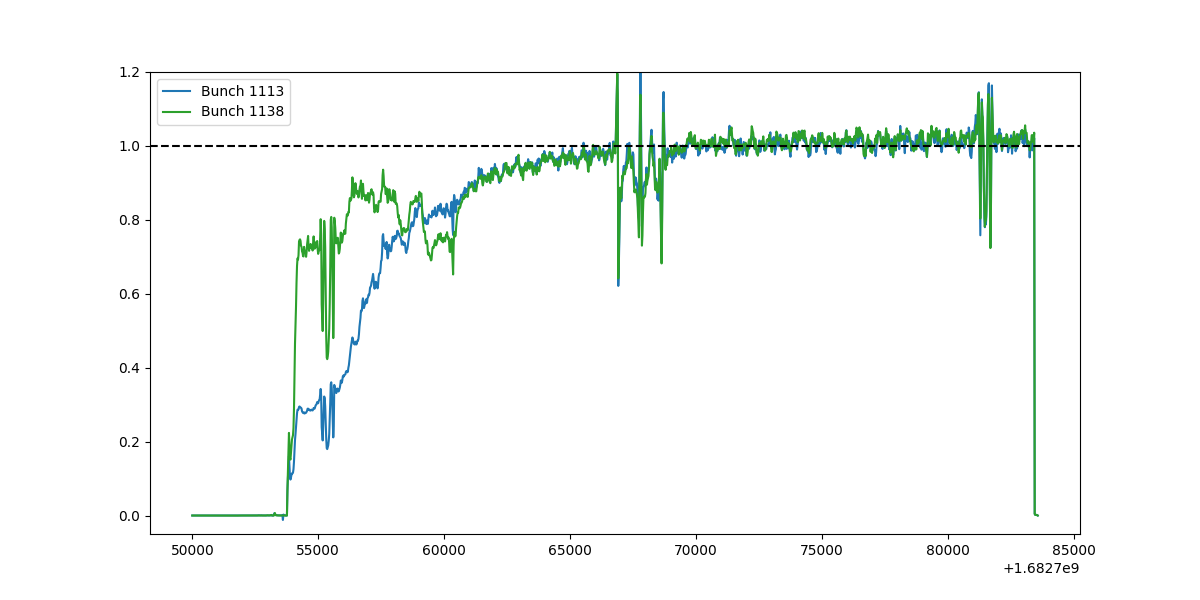

In [8]:


plt.figure(figsize=(12,6))
for bunch,color in zip(bunches,['C0','C2']):

    observable = 'B2:eta'
    data = df_eff[observable].dropna().apply(lambda line:line[bunch])
    plt.plot(data.index/1e9,data.values,color=color,label=f'Bunch {bunch}')
plt.legend()
plt.ylim([-0.05,1.2])
plt.axhline(1,color='k',linestyle='--')
# plt.plot()

# Losses

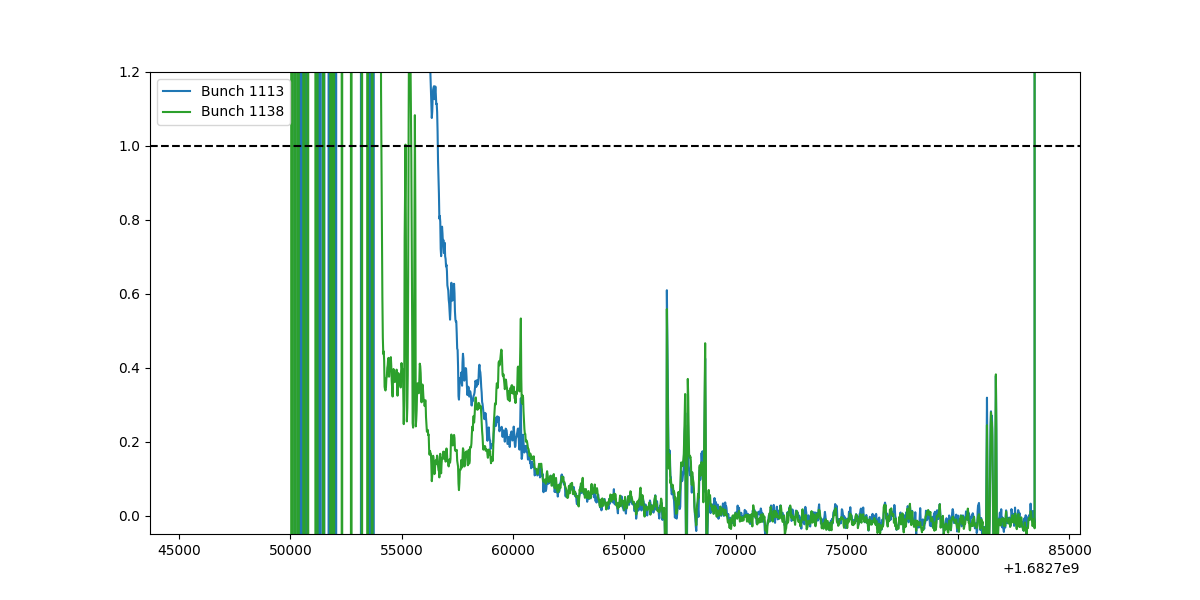

In [9]:


plt.figure(figsize=(12,6))
for bunch,color in zip(bunches,['C0','C2']):

    observable = 'B2:eta'
    data = df_eff[observable].dropna().apply(lambda line:line[bunch])
    plt.plot(data.index/1e9,1/data.values - 1,color=color,label=f'Bunch {bunch}')
plt.legend()
plt.ylim([-0.05,1.2])
plt.axhline(1,color='k',linestyle='--')
# plt.plot()

/tmp/ipykernel_175782/3298752759.py:184: RuntimeWarning: divide by zero encountered in divide
  eta      = cst.SIG_PP*data_L/(-dNdt)


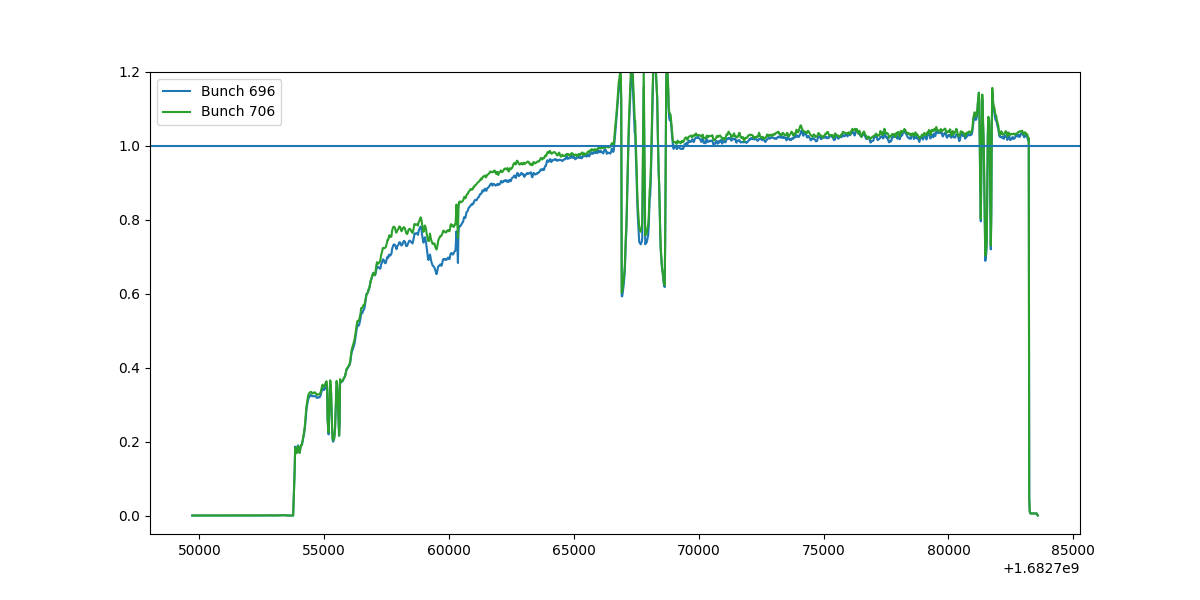

In [61]:


_tmp   = pd.concat([bct_avg,df_lumi_tot],axis=1).sort_index()
df_eff = compute_BCTF_efficiency2(_tmp,beams,smooth_params=[30,1])

plt.figure(figsize=(12,6))
for bunch,color in zip(bunches,['C0','C2']):

    observable = 'B2:eta'
    data = df_eff[observable].dropna().apply(lambda line:line[bunch])
    plt.plot(data.index/1e9,data.values,color=color,label=f'Bunch {bunch}')
plt.legend()
plt.ylim([-0.05,1.2])
plt.axhline(1)
# plt.plot()b

/tmp/ipykernel_175782/3298752759.py:184: RuntimeWarning: divide by zero encountered in divide
  eta      = cst.SIG_PP*data_L/(-dNdt)


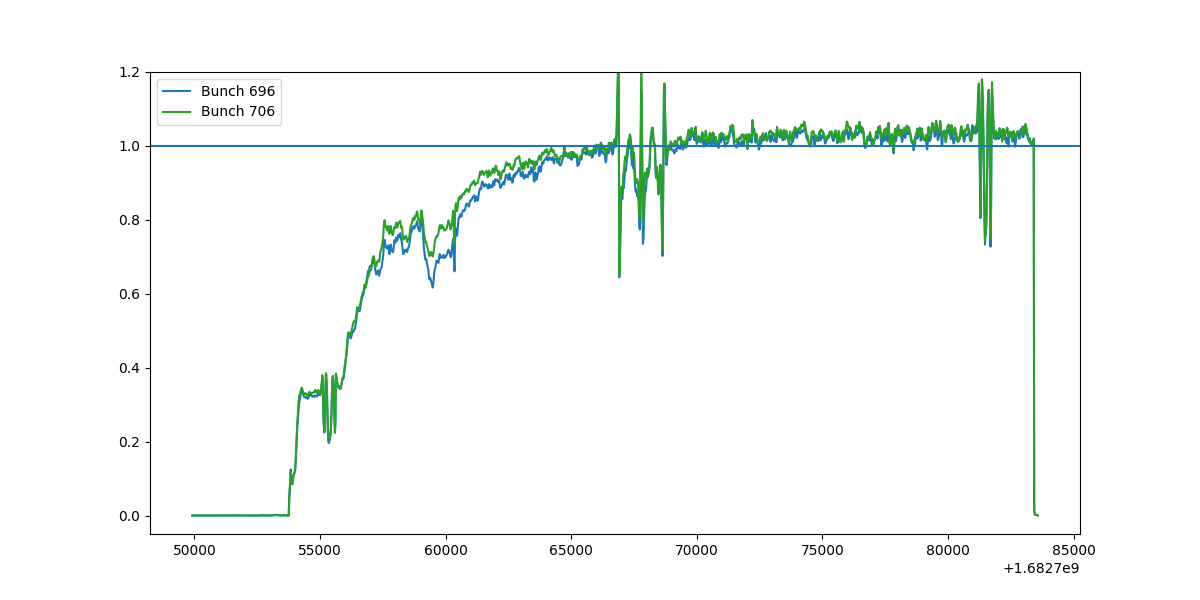

In [62]:


_tmp   = pd.concat([bct_avg,df_lumi_tot],axis=1).sort_index()
df_eff = compute_BCTF_efficiency2(_tmp,beams,smooth_params=[10,1])

plt.figure(figsize=(12,6))
for bunch,color in zip(bunches,['C0','C2']):

    observable = 'B2:eta'
    data = df_eff[observable].dropna().apply(lambda line:line[bunch])
    plt.plot(data.index/1e9,data.values,color=color,label=f'Bunch {bunch}')
plt.legend()
plt.ylim([-0.05,1.2])
plt.axhline(1)
# plt.plot()b

/tmp/ipykernel_175782/3298752759.py:184: RuntimeWarning: divide by zero encountered in divide
  eta      = cst.SIG_PP*data_L/(-dNdt)


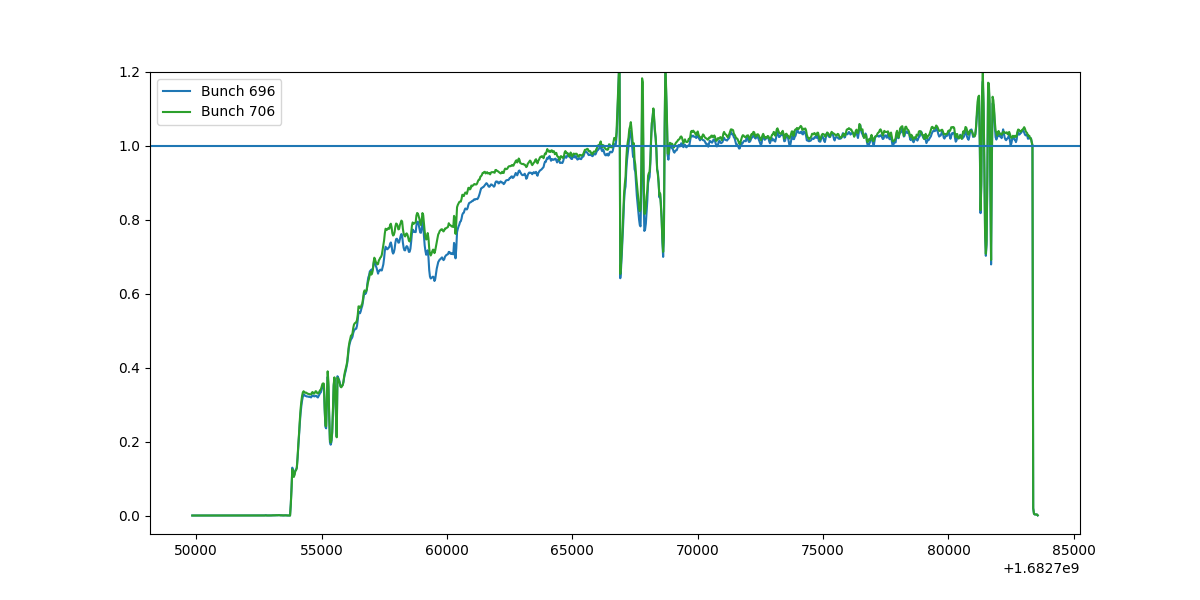

In [50]:


_tmp   = pd.concat([bct_avg,df_lumi_tot],axis=1).sort_index()
df_eff = compute_BCTF_efficiency2(_tmp,beams,smooth_params=[10,1])

plt.figure(figsize=(12,6))
for bunch,color in zip(bunches,['C0','C2']):

    observable = 'B2:eta'
    data = df_eff[observable].dropna().apply(lambda line:line[bunch])
    plt.plot(data.index/1e9,data.values,color=color,label=f'Bunch {bunch}')
plt.legend()
plt.ylim([-0.05,1.2])
plt.axhline(1)
# plt.plot()b

/tmp/ipykernel_175782/4179601898.py:184: RuntimeWarning: divide by zero encountered in divide
  eta      = cst.SIG_PP*data_L/(-dNdt)


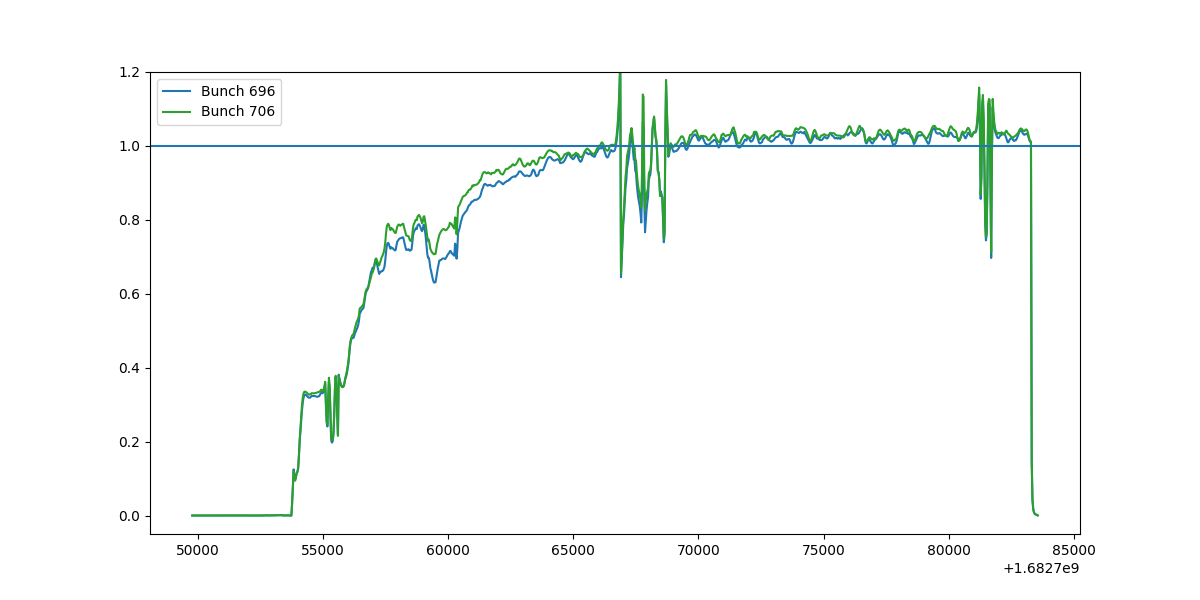

In [53]:


_tmp   = pd.concat([bct_avg,df_lumi_tot],axis=1).sort_index()
df_eff = compute_BCTF_efficiency2(_tmp,beams,smooth_params=[15,1])

plt.figure(figsize=(12,6))
for bunch,color in zip(bunches,['C0','C2']):

    observable = 'B2:eta'
    data = df_eff[observable].dropna().apply(lambda line:line[bunch])
    plt.plot(data.index/1e9,data.values,color=color,label=f'Bunch {bunch}')
plt.legend()
plt.ylim([-0.05,1.2])
plt.axhline(1)
# plt.plot()b

/tmp/ipykernel_175782/3298752759.py:184: RuntimeWarning: divide by zero encountered in divide
  eta      = cst.SIG_PP*data_L/(-dNdt)


(-0.05, 1.2)

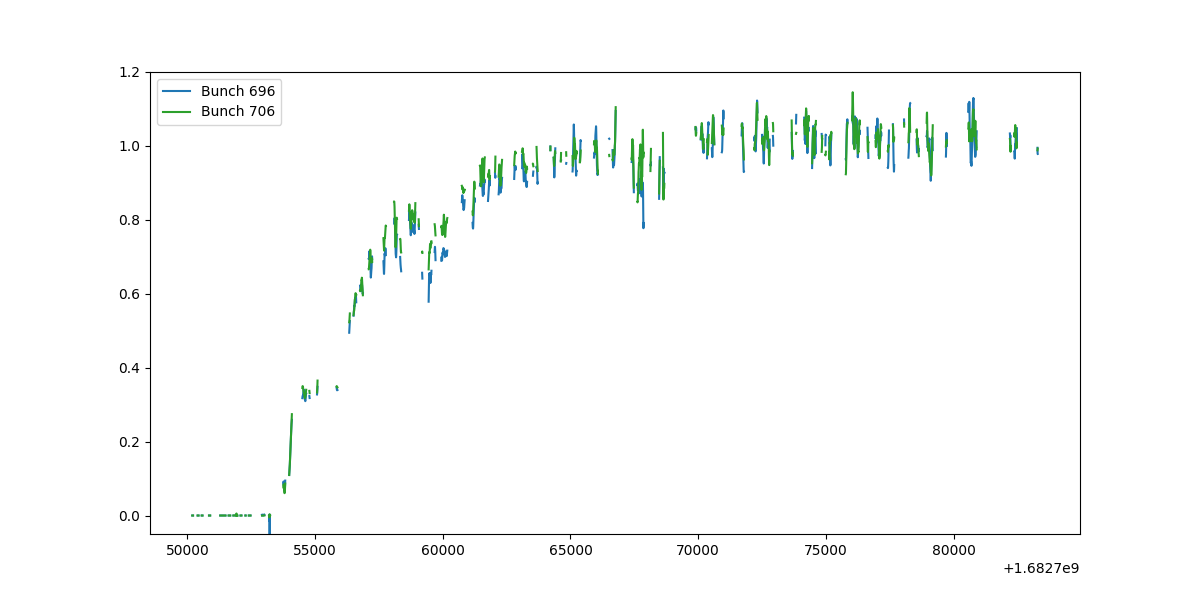

In [41]:


_tmp   = pd.concat([bct_avg,df_lumi_tot],axis=1).sort_index()
df_eff = compute_BCTF_efficiency2(_tmp,beams,smooth_params=[10,2])

plt.figure(figsize=(12,6))
for bunch,color in zip(bunches,['C0','C2']):

    observable = 'B2:eta'
    data = df_eff[observable].dropna().apply(lambda line:line[bunch])
    plt.plot(data.index/1e9,data.values,color=color,label=f'Bunch {bunch}')
plt.legend()
plt.ylim([-0.05,1.2])
# plt.plot()b

(-0.05, 10.0)

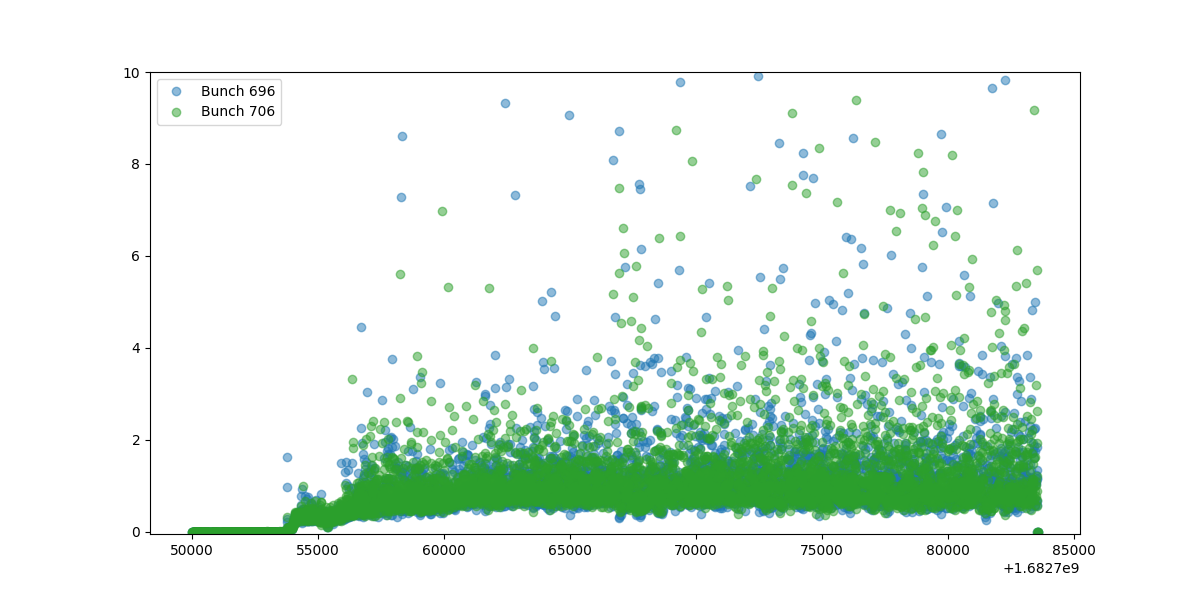

In [9]:


plt.figure(figsize=(12,6))
for bunch,color in zip(bunches,['C0','C2']):

    observable = 'B2:eta'
    data = df_eff[observable].dropna().apply(lambda line:line[bunch])
    plt.plot(data.index/1e9,data.values,'o',alpha=0.5,color=color,label=f'Bunch {bunch}')
plt.legend()
plt.ylim([-0.05,10])
# plt.plot()

(-0.05, 10.0)

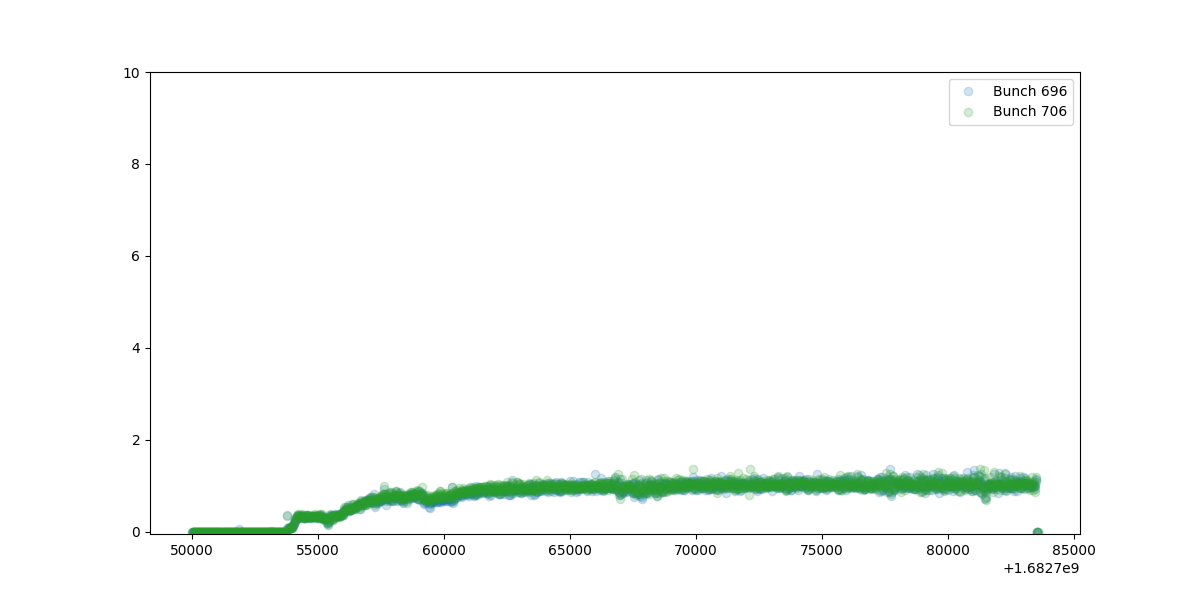

In [66]:


plt.figure(figsize=(12,6))
for bunch,color in zip(bunches,['C0','C2']):

    observable = 'B2:eta'
    data = df_eff[observable].dropna().apply(lambda line:line[bunch])
    plt.plot(data.index/1e9,data.values,'o',alpha=0.2,color=color,label=f'Bunch {bunch}')
plt.legend()
plt.ylim([-0.05,10])
# plt.plot()

(-0.05, 10.0)

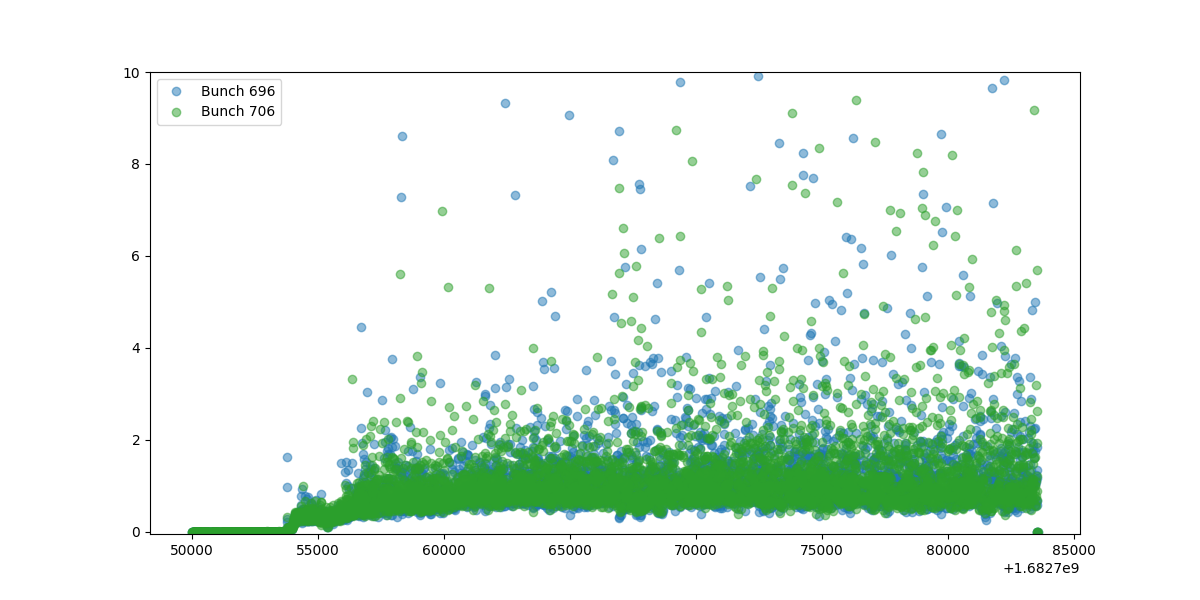

In [26]:


plt.figure(figsize=(12,6))
for bunch,color in zip(bunches,['C0','C2']):

    observable = 'B2:eta'
    data = df_eff[observable].dropna().apply(lambda line:line[bunch])
    plt.plot(data.index/1e9,data.values,'o',alpha=0.5,color=color,label=f'Bunch {bunch}')
plt.legend()
plt.ylim([-0.05,10])
# plt.plot()